
# Convolution Effects on Images — Gaussian, Sobel (Edges), Laplacian, Sharpen (PyTorch)

This notebook demonstrates **2D convolution** on images using classic filters:
- Gaussian blur (smoothing)
- Horizontal/Vertical edges (Sobel & Prewitt) + gradient magnitude
- Laplacian (second derivative)
- Sharpen (unsharp mask), Box blur, Emboss

It uses **PyTorch** for convolution and auto-selects **CUDA or Apple Metal (MPS)** if available.


In [17]:

import os, math, numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_device()
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
    print("CUDA:", torch.cuda.get_device_name(0))
elif DEVICE.type == "mps":
    print("Apple Metal (MPS) backend active")


Using device: cuda
CUDA: NVIDIA GeForce RTX 3090



## 1) Load an image (or use a synthetic demo)
Set `IMG_PATH` (string or `None`). If `None`, we generate a synthetic pattern that shows edges clearly.


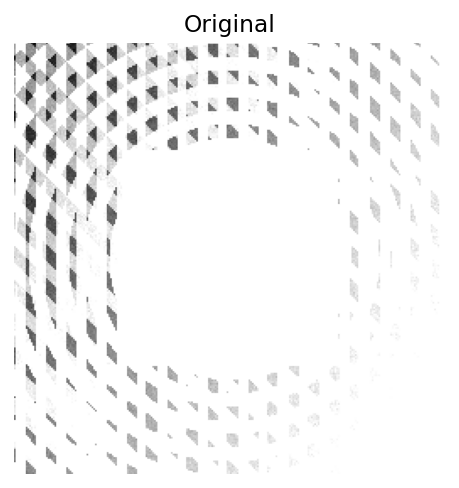

In [18]:

from pathlib import Path

IMG_PATH = None #'images/landscape.png' #None

def make_synthetic(h=256, w=256, seed=0):
    rng = np.random.default_rng(seed)
    y, x = np.ogrid[:h, :w]
    grad = (x / w) * 0.6 + (y / h) * 0.4
    stripes = 0.5 * (np.sin(2*np.pi*(x/12.0)) > 0).astype(float)
    circles = (((x-w//2)**2 + (y-h//2)**2)**0.5 % 16 < 8).astype(float) * 0.5
    box = np.zeros((h,w), float); box[h//4:3*h//4, w//4:3*w//4] = 0.7
    diag = ((x - y) % 20 < 10).astype(float) * 0.4
    noise = rng.normal(0, 0.03, (h,w))
    img = np.clip(0.2 + grad + stripes + circles + box + diag + noise, 0, 1)
    return img.astype(np.float32)

def load_or_make_image(path=None):
    if path is not None and Path(path).exists():
        import imageio.v2 as imageio
        img = imageio.imread(path)
        if img.ndim == 3:
            img = img[..., :3]
            weights = np.array([0.299, 0.587, 0.114], dtype=np.float32)
            img = (img * weights).sum(axis=2) / (255.0 if img.max() > 1.0 else 1.0)
        else:
            img = img.astype(np.float32)
            if img.max() > 1.0:
                img = img / 255.0
        return img.astype(np.float32)
    return make_synthetic()

IMG = load_or_make_image(IMG_PATH)
plt.figure(figsize=(4,4), dpi=140)
plt.imshow(IMG, cmap="gray"); plt.title("Original"); plt.axis("off"); plt.show()


## 2) Convolution helpers & kernels

In [19]:

def to_tensor(im):
    return torch.from_numpy(im).float().unsqueeze(0).unsqueeze(0).to(DEVICE)

def to_numpy(t):
    return t.squeeze().detach().cpu().numpy()

def conv2d_same(im, k):
    x = to_tensor(im)
    k = torch.from_numpy(k).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
    ph, pw = k.shape[-2]//2, k.shape[-1]//2
    y = F.conv2d(x, k, padding=(ph,pw))
    return to_numpy(y)

def gaussian_kernel(ks=5, sigma=1.0):
    ax = torch.arange(ks) - ks//2
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    k = torch.exp(-(xx**2 + yy**2) / (2*sigma**2))
    k = k / k.sum()
    return k.numpy()

SOBEL_X = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
SOBEL_Y = SOBEL_X.T.copy()
PREWITT_X = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float32)
PREWITT_Y = PREWITT_X.T.copy()
LAPLACIAN_4 = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=np.float32)
LAPLACIAN_8 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], dtype=np.float32)

def box_kernel(ks=3):
    k = np.ones((ks,ks), np.float32); k /= k.sum(); return k

def unsharp_mask(img, ks=5, sigma=1.0, alpha=1.0):
    g = conv2d_same(img, gaussian_kernel(ks, sigma))
    return np.clip(img + alpha*(img - g), 0, 1)

EMBOSS = np.array([[-2,-1,0],[-1,1,1],[0,1,2]], dtype=np.float32)


## 3) Apply filters

In [20]:

img = IMG

g1 = conv2d_same(img, gaussian_kernel(5, 0.8))
g2 = conv2d_same(img, gaussian_kernel(9, 1.6))

sx = conv2d_same(img, SOBEL_X)
sy = conv2d_same(img, SOBEL_Y)
grad_mag = np.hypot(sx, sy); grad_mag /= grad_mag.max() + 1e-8

px = conv2d_same(img, PREWITT_X)
py = conv2d_same(img, PREWITT_Y)
prewitt_mag = np.hypot(px, py); prewitt_mag /= prewitt_mag.max() + 1e-8

lap4 = conv2d_same(img, LAPLACIAN_4)
lap8 = conv2d_same(img, LAPLACIAN_8)

sharp = unsharp_mask(img, ks=5, sigma=1.0, alpha=1.0)
box3 = conv2d_same(img, box_kernel(3))
box7 = conv2d_same(img, box_kernel(7))

emb = conv2d_same(img, EMBOSS)
emb_v = (emb - emb.min()) / (emb.max() - emb.min() + 1e-8)

print("Computed all filter outputs.")


Computed all filter outputs.


## 4) Visualize results

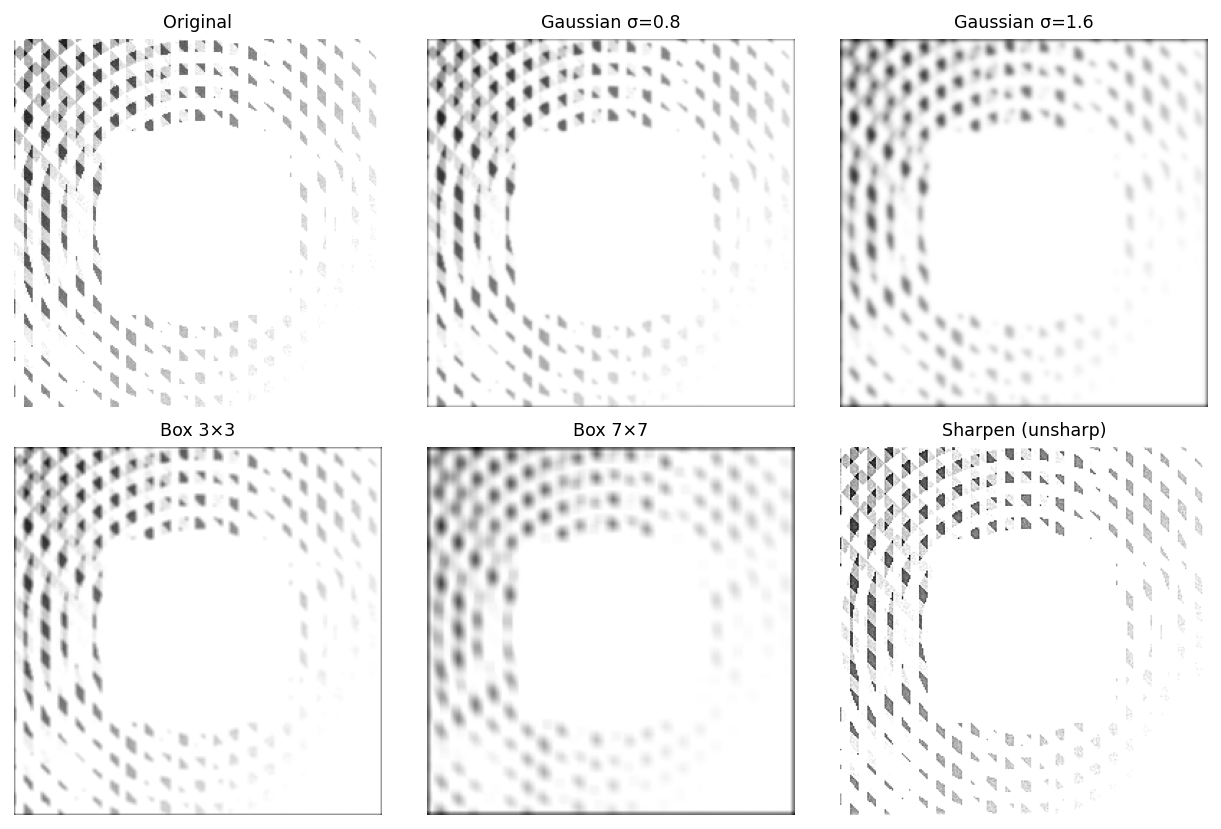

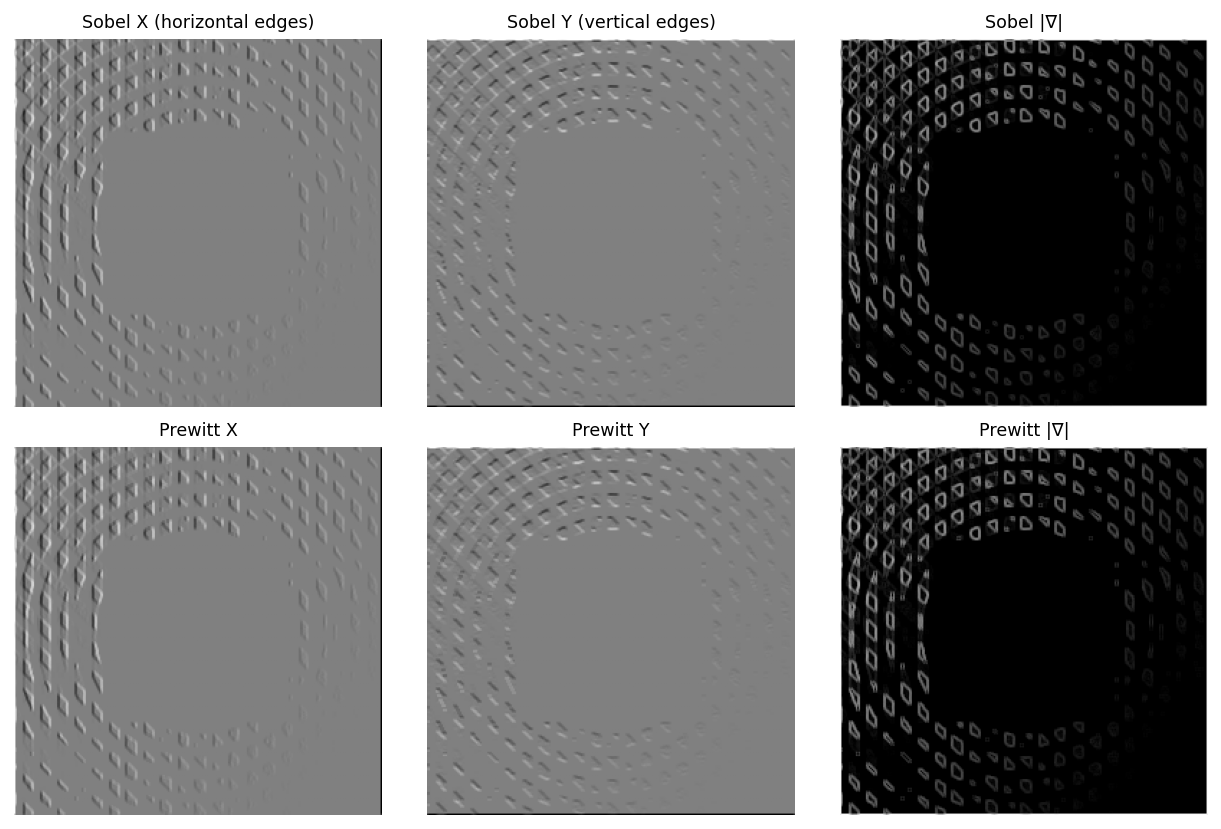

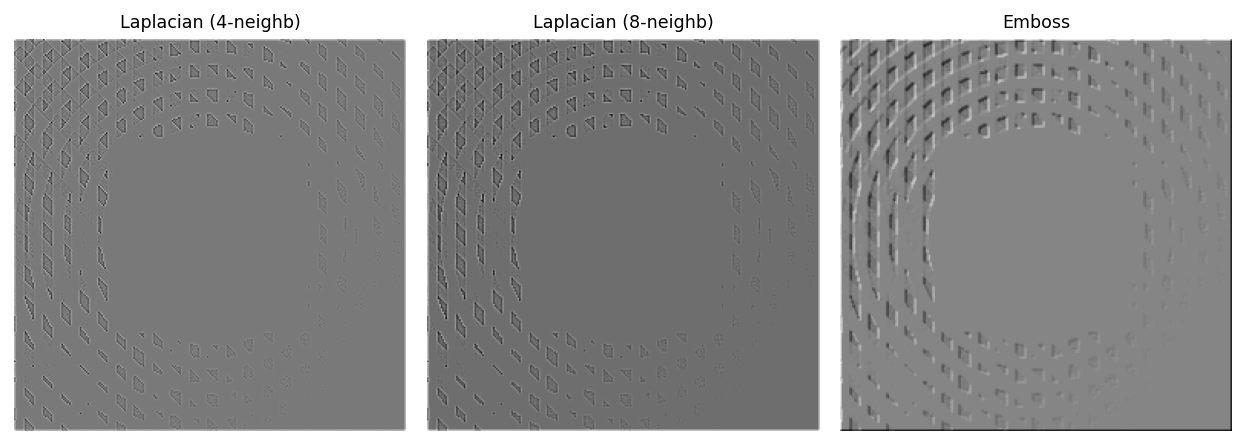

In [21]:

def show_grid(imgs, titles, rows, cols, figsize=(10,8)):
    import matplotlib.pyplot as plt
    assert len(imgs) == len(titles) == rows*cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=140)
    for ax, im, t in zip(axes.ravel(), imgs, titles):
        ax.imshow(im, cmap="gray")
        ax.set_title(t, fontsize=9)
        ax.axis("off")
    plt.tight_layout(); plt.show()

show_grid(
    [img, g1, g2, box3, box7, sharp],
    ["Original","Gaussian σ=0.8","Gaussian σ=1.6","Box 3×3","Box 7×7","Sharpen (unsharp)"],
    rows=2, cols=3, figsize=(9,6)
)

show_grid(
    [sx, sy, grad_mag, px, py, prewitt_mag],
    ["Sobel X (horizontal edges)","Sobel Y (vertical edges)","Sobel |∇|",
     "Prewitt X","Prewitt Y","Prewitt |∇|"],
    rows=2, cols=3, figsize=(9,6)
)

def zero_center_to_view(a):
    m = max(abs(a.max()), abs(a.min())) + 1e-8
    return 0.5 + 0.5 * (a / m)

show_grid(
    [zero_center_to_view(lap4), zero_center_to_view(lap8), emb_v],
    ["Laplacian (4-neighb)","Laplacian (8-neighb)","Emboss"],
    rows=1, cols=3, figsize=(9,3.2)
)


## 5) Padding/stride intuition (tiny example)

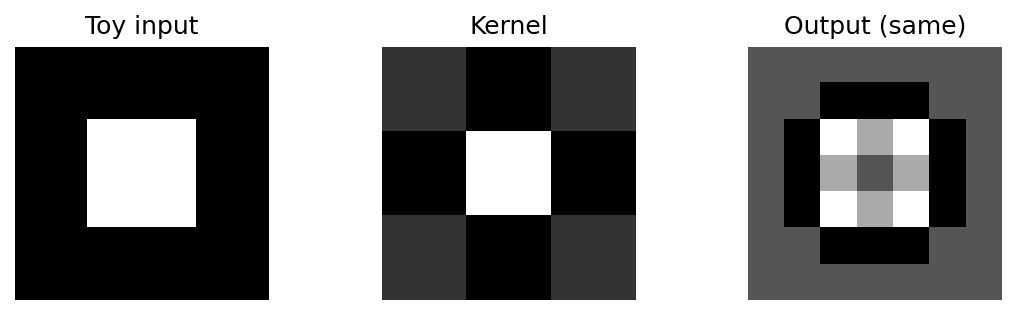

In [22]:

toy = np.zeros((7,7), dtype=np.float32); toy[2:5, 2:5] = 1.0
k3 = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=np.float32)
y_same = conv2d_same(toy, k3)

plt.figure(figsize=(7.5,2.2), dpi=150)
plt.subplot(1,3,1); plt.imshow(toy, cmap="gray"); plt.title("Toy input"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(k3, cmap="gray"); plt.title("Kernel"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(y_same, cmap="gray"); plt.title("Output (same)"); plt.axis("off")
plt.tight_layout(); plt.show()



### Tips
- Tune Gaussian `sigma` and kernel size for stronger/weaker blur.
- `unsharp_mask` uses `alpha`—increase for stronger sharpening (can amplify noise).
- Replace `IMG_PATH` with your own image path to try on real photos.
